# Twitter User Gender Classification
Predict user gender based on Twitter profile information

### Table of Contents:
1. Understanding Dataset
2. Cleaning Dataset
3. Visualizing Dataset
4. Classification Modeling

In [87]:
# Import libraries

!pip install tensorflow
!pip install eli5
!pip install tensorflow keras
import eli5
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Handling text data
import re
import regex
import nltk
from collections import Counter
from nltk.stem import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Understanding Dataset

This dataset is obtained from [Kaggle](https://www.kaggle.com/crowdflower/twitter-user-gender-classification).

The dataset contains 20,000 rows, each with a user name, a random tweet, account profile and image, location, and even link and sidebar color.

Attributes that do not provide useful information for *Gender classification*:
 - **_unit_id**: a unique id for user
 - **_last_judgment_at**: date and time of last contributor judgment; blank for gold standard observations
 - **user_timezone**: the timezone of the user
 - **tweet_coord**: if the user has location turned on, the coordinates as a string with the format "[latitude, longitude]"
 - **tweet_created**: when the random tweet (in the text column) was created
 - **tweet_id**: the tweet id of the random tweet
 - **tweet_location**: location of the tweet; seems to not be particularly normalized
 - **profileimage**: a link to the profile image
 - **created**: date and time when the profile was created


Attributes that potentially provide useful information for *Gender classification*:
 - **_golden**: whether the user was included in the gold standard for the model; TRUE or FALSE
 - **_unit_state**: state of the observation; one of finalized (for contributor-judged) or golden (for gold standard observations)
 - **_trusted_judgments**: number of trusted judgments (int); always 3 for non-golden, and what may be a unique id for gold standard observations
 - **gender**: one of male, female, or brand (for non-human profiles)
 - **gender:confidence**: a float representing confidence in the provided gender
 - **gender_gold**: if the profile is golden, what is the gender?
 - **profile_yn**: "no" here seems to mean that the profile was meant to be part of the dataset but was not available when contributors went to judge it
 - **profile_yn:confidence**: confidence in the existence/non-existence of the profile
 - **profile_yn_gold**: whether the profile y/n value is golden
 - **description**: the user's profile description
 - **fav_number**: number of tweets the user has favorited
 - **link_color**: the link color on the profile, as a hex value
 - **name**: the user's name
 - **retweet_count**: number of times the user has retweeted (or possibly, been retweeted)
 - **sidebar_color**: color of the profile sidebar, as a hex value
 - **text**: text of a random one of the user's tweets
 - **tweet_count**: number of tweets that the user has posted


In [88]:
# Load dataset
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/gender_dataset.csv", encoding='latin-1')
#data = pd.read_csv('gender_dataset.csv', encoding='latin-1')

# Drop unnecessary columns/features
data.drop (columns = ['_unit_id',
                      '_last_judgment_at',
                      'user_timezone',
                      'tweet_coord',
                      'tweet_created',
                      'tweet_id',
                      'tweet_location',
                      'profileimage',
                      'created',
                      'name'], inplace = True)

data.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _golden                20050 non-null  bool   
 1   _unit_state            20050 non-null  object 
 2   _trusted_judgments     20050 non-null  int64  
 3   gender                 19953 non-null  object 
 4   gender:confidence      20024 non-null  float64
 5   profile_yn             20050 non-null  object 
 6   profile_yn:confidence  20050 non-null  float64
 7   description            16306 non-null  object 
 8   fav_number             20050 non-null  int64  
 9   gender_gold            50 non-null     object 
 10  link_color             20050 non-null  object 
 11  profile_yn_gold        50 non-null     object 
 12  retweet_count          20050 

In [89]:
data.head(3)

,_golden,_unit_state,_trusted_judgments,gender,gender:confidence,profile_yn,profile_yn:confidence,description,fav_number,gender_gold,link_color,profile_yn_gold,retweet_count,sidebar_color,text,tweet_count
0,False,finalized,3,male,1.0000,yes,1.0,i sing my own rhythm.,0,NaN,08C2C2,NaN,0,FFFFFF,Robbie E Responds To Critics After Win Against...,110964
1,False,finalized,3,male,1.0000,yes,1.0,I'm the author of novels filled with family dr...,68,NaN,0084B4,NaN,0,C0DEED,ÛÏIt felt like they were my friends and I was...,7471
2,False,finalized,3,male,0.6625,yes,1.0,louis whining and squealing and all,7696,NaN,ABB8C2,NaN,1,C0DEED,i absolutely adore when louis starts the songs...,5617


In [90]:
data.describe()

,_trusted_judgments,gender:confidence,profile_yn:confidence,fav_number,retweet_count,tweet_count
count,20050.000000,20024.000000,20050.000000,20050.000000,20050.000000,2.005000e+04
mean,3.615711,0.882756,0.993221,4382.201646,0.079401,3.892469e+04
std,12.331890,0.191403,0.047168,12518.575919,2.649751,1.168371e+05
min,3.000000,0.000000,0.627200,0.000000,0.000000,1.000000e+00
25%,3.000000,0.677800,1.000000,11.000000,0.000000,2.398000e+03
50%,3.000000,1.000000,1.000000,456.000000,0.000000,1.144150e+04
75%,3.000000,1.000000,1.000000,3315.500000,0.000000,4.002750e+04
max,274.000000,1.000000,1.000000,341621.000000,330.000000,2.680199e+06


## 2. Cleaning Dataset

### Target variable: `Gender`

In [91]:
data['gender'].value_counts()

female     6700
male       6194
brand      5942
unknown    1117
Name: gender, dtype: int64

In [92]:
# We can see that there are 1117 unknown genders, so get rid of them
unknown_items_idx = data[data['gender'] == 'unknown'].index
data.drop (index = unknown_items_idx, inplace = True)
data['gender'].value_counts()

female    6700
male      6194
brand     5942
Name: gender, dtype: int64

### 'Profile' Attribute (profile_yn, profile_yn:confidence, profile_yn_gold)
**'No'**: Profile was meant to be part of the dataset but was not available when contributors went to judge it.

In [93]:
print('Profile_yn information:\n',data['profile_yn'].value_counts())
print('-'*40)
print('Number of NaN instances when profile_yn is No: ', data[data['profile_yn'] == 'no']['gender'].isnull().sum())

Profile_yn information:
 yes    18836
no        97
Name: profile_yn, dtype: int64
----------------------------------------
Number of NaN instances when profile_yn is No:  97


It is shown that all of 97 instances with **profile_yn** == **no** are all **NaN** in **gender**. Therefore, i get rid of these 97 instances for now.

At this point, `profile_yn`  seems not to be informative towards the target. Therefore, i also eliminate **profile_yn**, **profile_yn:confidence** and **profile_yn_gold** as they are not useful anymore.

In [94]:
drop_items_idx = data[data['profile_yn'] == 'no'].index
data.drop (index = drop_items_idx, inplace = True)
data.drop (columns = ['profile_yn','profile_yn:confidence','profile_yn_gold'], inplace = True)

### Low-confidence gender (gender:confidence)

I decide to keep only 100% confidence of labeling Gender and get rid of those < 100% confidence.

In [95]:
print ('Full data items: ', data.shape)
print ('Data with label-confidence < 100%: ', data[data['gender:confidence'] < 1].shape)

Full data items:  (18836, 13)
Data with label-confidence < 100%:  (5032, 13)


Approximately **26.7%** (5032/18836) of labeled instances were lower 100% of confidence

Eliminate those instances and the feature **gender:confidence** as it is not useful anymore.

In [96]:
drop_items_idx = data[data['gender:confidence'] < 1].index
data.drop (index = drop_items_idx, inplace = True)
data.drop (columns = ['gender:confidence'], inplace = True)

### Getting rid of remaining useless features

In [97]:
data.drop (columns = ['_golden','_unit_state','_trusted_judgments','gender_gold'], inplace = True)

# Double check the data
print (data['gender'].value_counts())
print ('-'*40)
data.info()

female    5367
male      4653
brand     3784
Name: gender, dtype: int64
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13804 entries, 0 to 20049
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         13804 non-null  object
 1   description    11773 non-null  object
 2   fav_number     13804 non-null  int64 
 3   link_color     13804 non-null  object
 4   retweet_count  13804 non-null  int64 
 5   sidebar_color  13804 non-null  object
 6   text           13804 non-null  object
 7   tweet_count    13804 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 970.6+ KB


In [98]:
data.describe()

,fav_number,retweet_count,tweet_count
count,13804.000000,13804.000000,1.380400e+04
mean,4235.962692,0.068169,3.807311e+04
std,12162.666724,1.420828,1.251379e+05
min,0.000000,0.000000,1.000000e+00
25%,22.000000,0.000000,2.221750e+03
50%,530.000000,0.000000,1.009500e+04
75%,3374.250000,0.000000,3.714150e+04
max,341621.000000,153.000000,2.680199e+06


### Cleaning Textual Data

In [99]:
stop = stopwords.words('english')
porter = PorterStemmer()

def preprocessor(text):
    """
    Return a cleaned version of text, but keeping the emoticons
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Remove url tokens
    text = re.sub('http.*', ' ', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-alphanumeric character and append the emoticons,
    # removing the nose character of emoji for standarization. Convert to lower case
    text = re.sub('[^a-zA-Z0-9]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', '')

    return text

def remove_dup_whitespace(text):
    """
    This function removes duplicated whitespaces of a string
    """
    return re.sub('\s{2,}', ' ',text)

def tokenizer_porter(text):
    """
    This function tokenize and also perform stemming
    """
    return [porter.stem(word) for word in text.lower().split()]

def clean_tweet(text):
    """
    This function tokenizes whole tweet into tokens,
    Then clean it, remove stopwords and combine back as a tweet.

    In other words, this function combines all 3 above functions
    """
    clean = ""
    tokens = tokenizer_porter(text)
    for token in tokens:
        if len(token)> 1:
            if token not in stop:
                clean += preprocessor(token)
    return remove_dup_whitespace(clean)

#### Hanlding missing values of `description`

In [100]:
def has_nan(X):
    '''
    Input: Dataframe
    This func check if the features of a DataFrame has missing values or not
    '''
    X_ = X.isnull()
    X_ = X_.add_suffix('_has_nan')
    return X_

has_nan_df = has_nan(data[['description']])
data = pd.concat([data, has_nan_df], axis=1)

# Fill NaN with empty strings
data['description'].fillna("", inplace=True)

In [101]:
data[['text','description']] = data[['text','description']].applymap(clean_tweet)

## 3. Visualizing Data

Among text data, i want to find out if other features can give me useful information or show some special characteristics.

### Target

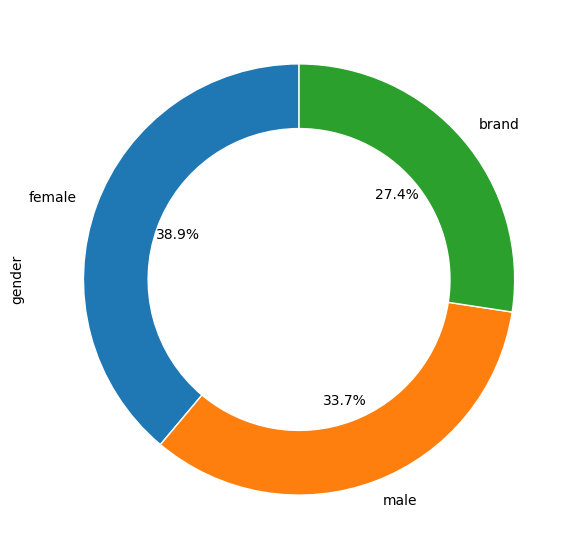

In [102]:
plt.figure(figsize=(7,7))
data['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                  startangle=90, wedgeprops=dict(width=0.3, edgecolor='w'))
plt.show()

### `favorites`, `tweets` and `retweets` vs Label

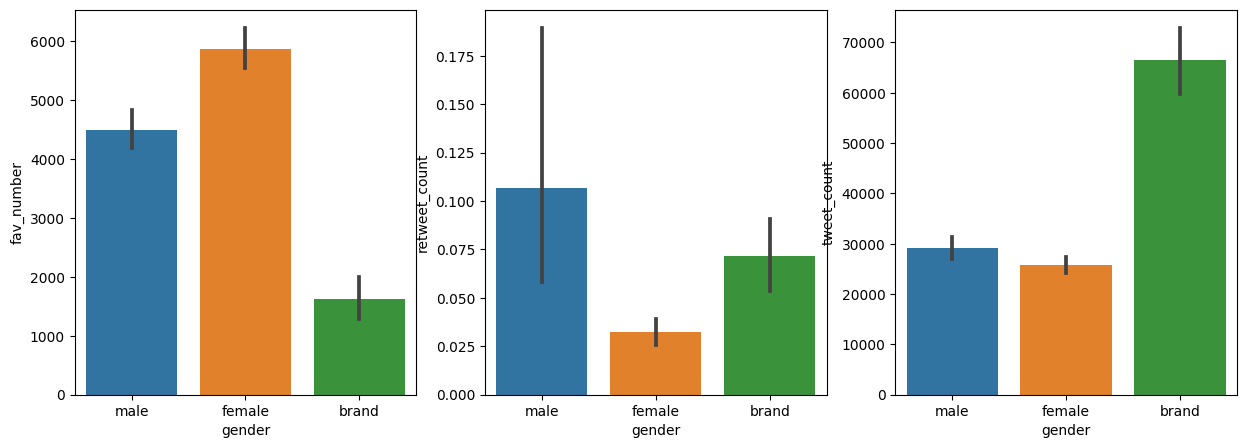

In [103]:
plt.figure(figsize=(15,5))

for i,j in enumerate(['fav_number','retweet_count','tweet_count']):
    plt.subplot(1,3,i+1)
    sns.barplot (x = 'gender', y = j,data = data)

plt.show()

### Visualize `Color` features

In [104]:
def visualize_color(color_feature, data):
    if (color_feature) not in data.columns:
        return 'Invalid color feature'

    # Clean color map that misses prefix 0s
    clean_color_map = lambda x: "0"*(6-len(x))+x if len(x)<6 else x

    genders = ['male','female','brand']
    plt.figure(figsize=(15,5))
    for i, j in enumerate(genders):
        plt.subplot(1,len(genders),i+1)
        plt.gca().set_title(j + '_' + color_feature)
        top_color_count = data[data['gender'] == j][color_feature].value_counts().head(7)
        top_color = top_color_count.index.values
        top_color = list(map(clean_color_map, top_color))
        plt.gca().set_facecolor('xkcd:salmon')
        sns.barplot (x = top_color_count, y = top_color,
                     palette=list(map(lambda x: '#'+x, top_color)))
    plt.show()

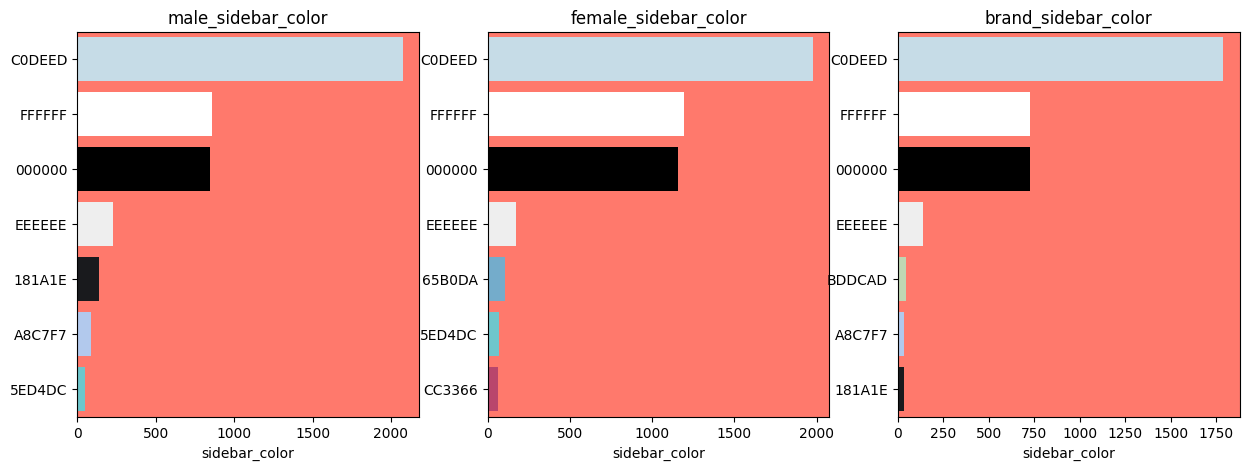

In [105]:
visualize_color('sidebar_color', data)

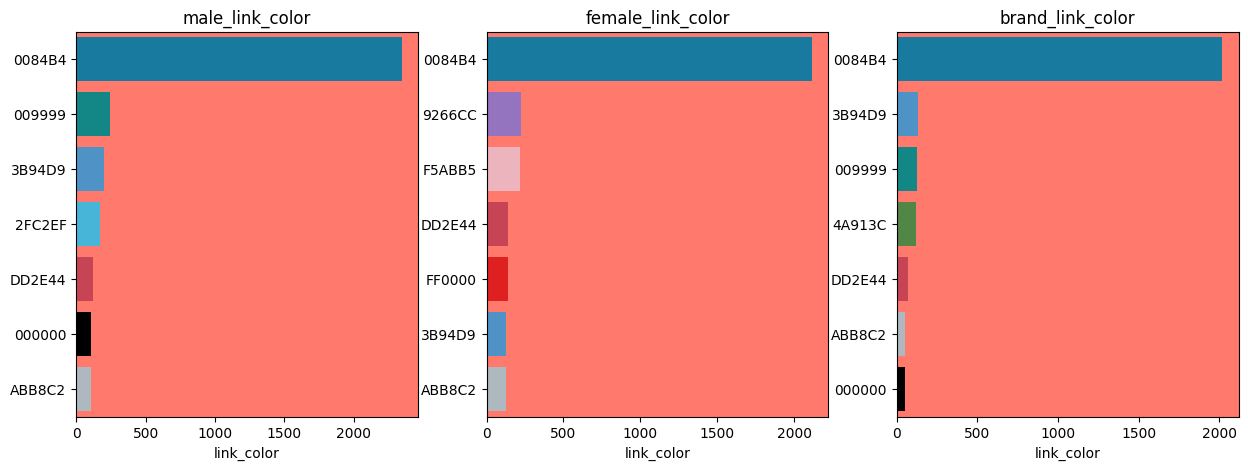

In [106]:
visualize_color('link_color', data)

For `sidebar color`, the top 3 colors are the same (this seems to be these colors are default theme color of Twitter). It is shown that the number of 2nd and 3rd color of female is larger but this can be explained by the fact that the number of female users are more than male.

For `link_color`, except for the most common color, which is the theme color of Twitter, we can see that there are differences for other color preferences between male and female.

We can group the most common color map of features `link_color` and `sidebar_color` to `theme_color`, then we can make these 2 features useful for predicting the Gender.

## 4. Classification modeling

### 4.1 with Tweet-text only

# **#### How relevant are words? Term frequency-inverse document frequency (TF-IDF)**

We could use these raw term frequencies to score the words in our algorithm. There is a problem though: If a word is very frequent in _all_ documents, then it probably doesn't carry a lot of information. In order to tacke this problem we can use **term frequency-inverse document frequency**, which will reduce the score the more frequent the word is accross all twits. It is calculated like this:

\begin{equation*}
tf-idf(t,d) = tf(t,d) ~ idf(t,d)
\end{equation*}

_tf(t,d)_ is the raw term frequency descrived above. _idf(t,d)_ is the inverse document frequency, than can be calculated as follows:

\begin{equation*}
\log \frac{n_d}{1+df\left(d,t\right)}
\end{equation*}

where `n` is the total number of documents (number of _twits_ in this problem) and _df(t,d)_ is the number of documents where the term `t` appears.

The `1` addition in the denominator is just to avoid zero term for terms that appear in all documents. Ans the `log` ensures that low frequency term don't get too much weight.

The IDF (inverse document frequency) of a word is the measure of how significant that term is in the whole corpus (the whole collection of _twits_ in this problem).

The higher the TF-IDF weight value, the rarer the term. The smaller the weight, the more common the term.

In [144]:
# Firstly, convert categorical labels into numerical ones
# Function for encoding categories
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(data['gender'])

# split the dataset in train and test
X = data['text']
# Stratify will create a train set with the same class balance than the original set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

X_train.head()

19087     rvpisarapist player liter give 110 show great...
11212    backer atrium lobbi consid join forc foyer lob...
14799    wa suppos receiv spirithalloween order today c...
6846     depress come least expect it like shittiest pe...
1226     grime throw fun bloodi parti flesh without blo...
Name: text, dtype: object

In [145]:
def classification_modeling(X_train, X_test, y_train, y_test, text_feature=False):
    """
    This function iterates different possible models
    and return corresponding accuracy

    Args:
        text_feature: Whether the model handles text features or not

    Return: The best fitted model
    """
    clf_dict = {'lr': LogisticRegression(multi_class='ovr', random_state=0),
                'rf': RandomForestClassifier(n_estimators = 50, random_state=0),
                'svm': SVC(kernel = 'rbf', probability=True),
                'nb': ComplementNB()
               }
    result_dict = dict.fromkeys(clf_dict, None)
    pred_dict = dict.fromkeys(clf_dict, None)

    for clf_key in clf_dict:
        if text_feature == True:
            tfidf = TfidfVectorizer()
            clf = Pipeline([('vect', tfidf),
                            ('clf', clf_dict[clf_key])])
        else:
            clf = clf_dict[clf_key]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        acc = accuracy_score(y_test,predictions)
        result_dict[clf_key] = acc
        pred_dict[clf_key] = predictions
        print('Fitting ' + clf_key + ' - Acc:', acc)
        print('Confusion matrix:\n',confusion_matrix(y_test,predictions))
        print('-'*40)

    win_clf = max(result_dict, key=lambda key: result_dict[key])
    print("Win classifier: ", win_clf, "- Acc: ",result_dict[win_clf])
    return np.asarray(pred_dict[win_clf])

In [152]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score

best_text_preds = classification_modeling(X_train, X_test, y_train, y_test, text_feature=True)

# Calculate and print classification report
print("Classification Report:")
print(classification_report(y_test, best_text_preds))

# Calculate and print F1-score
f1 = f1_score(y_test, best_text_preds, average='weighted')
print(f"F1-score: {f1:.4f}")

# Assuming `final_text_preds` is the predicted labels on the test set
# `y_test` contains the true labels
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test, num_classes=3))
print(f"ROC-AUC Score: {roc_auc:.4f}")

Fitting lr - Acc: 0.5463544181554805
Confusion matrix:
 [[ 587  282  267]
 [ 122 1091  397]
 [ 165  646  585]]
----------------------------------------
Fitting rf - Acc: 0.5217286335103815
Confusion matrix:
 [[ 524  409  203]
 [  92 1241  277]
 [ 125  875  396]]
----------------------------------------
Fitting svm - Acc: 0.5533558667310478
Confusion matrix:
 [[ 553  300  283]
 [  80 1148  382]
 [ 120  685  591]]
----------------------------------------
Fitting nb - Acc: 0.5509415741187832
Confusion matrix:
 [[ 641  295  200]
 [ 156 1173  281]
 [ 202  726  468]]
----------------------------------------
Win classifier:  svm - Acc:  0.5533558667310478
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.49      0.59      1136
           1       0.54      0.71      0.61      1610
           2       0.47      0.42      0.45      1396

    accuracy                           0.55      4142
   macro avg       0.58      0.54      0.55     

### 4.2 Concatenating `description` to `text`

In [110]:
# Concatenate text with description, add white space between.
# By using Series helper functions Series.str()
data['text_description'] = data['text'].str.cat(data['description'], sep=' ')

### Re-create training dataset

In [111]:
# split the dataset in train and test
X = data['text_description']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
#In the code line above, stratify will create a train set with the same class balance than the original set

X_train.head()
X_train.isnull().values.any() # Check if any null values, True if there is at least one.

False

In [162]:
best_text_preds = classification_modeling(X_train, X_test, y_train, y_test, text_feature=True)

# Calculate and print classification report
print("Classification Report:")
print(classification_report(y_test, best_text_preds))

# Calculate and print F1-score
f1 = f1_score(y_test, best_text_preds, average='weighted')
print(f"F1-score: {f1:.4f}")

# Assuming `final_text_preds` is the predicted labels on the test set
# `y_test` contains the true labels
y_probs = clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_probs, average='weighted', multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.4f}")


Fitting lr - Acc: 0.5463544181554805
Confusion matrix:
 [[ 587  282  267]
 [ 122 1091  397]
 [ 165  646  585]]
----------------------------------------
Fitting rf - Acc: 0.5217286335103815
Confusion matrix:
 [[ 524  409  203]
 [  92 1241  277]
 [ 125  875  396]]
----------------------------------------
Fitting svm - Acc: 0.5533558667310478
Confusion matrix:
 [[ 553  300  283]
 [  80 1148  382]
 [ 120  685  591]]
----------------------------------------
Fitting nb - Acc: 0.5509415741187832
Confusion matrix:
 [[ 641  295  200]
 [ 156 1173  281]
 [ 202  726  468]]
----------------------------------------
Win classifier:  svm - Acc:  0.5533558667310478
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.49      0.59      1136
           1       0.54      0.71      0.61      1610
           2       0.47      0.42      0.45      1396

    accuracy                           0.55      4142
   macro avg       0.58      0.54      0.55     

### 4.3 with non-text features

In [166]:
encoder = LabelEncoder()
y = encoder.fit_transform(data['gender'])

# split the dataset in train and test
X = data.drop(columns=['text','description','text_description', 'gender'])

### Handling categorical features
- `link_color` and `sidebar_color` has too many unique values, therefore, ordinary one-hot encoding will create a very large number of features.
- Solution: Use `labelcount_encode` as inspried by [wrosinki](https://wrosinski.github.io/fe_categorical_encoding/)

In [167]:
def labelcount_encode(X, categorical_features, ascending=False):
    '''
        Encoding function taken from, ref for description:
        https://wrosinski.github.io/fe_categorical_encoding/
    '''
    print('LabelCount encoding: {}'.format(categorical_features))
    X_ = pd.DataFrame()
    for cat_feature in categorical_features:
        cat_feature_value_counts = X[cat_feature].value_counts()
        value_counts_list = cat_feature_value_counts.index.tolist()
        if ascending:
            # for ascending ordering
            value_counts_range = list(
                reversed(range(len(cat_feature_value_counts))))
        else:
            # for descending ordering
            value_counts_range = list(range(len(cat_feature_value_counts)))
        labelcount_dict = dict(zip(value_counts_list, value_counts_range))
        X_[cat_feature] = X[cat_feature].map(
            labelcount_dict)
    X_ = X_.add_suffix('_labelcount_encoded')
    if ascending:
        X_ = X_.add_suffix('_ascending')
    else:
        X_ = X_.add_suffix('_descending')
    X_ = X_.astype(np.float)
    return X_

In [168]:
cat_features = ['link_color','sidebar_color']
encoded = labelcount_encode(X, cat_features)

X = pd.concat([X, encoded], axis=1)

X.drop(columns=cat_features, inplace=True)
X.info()

LabelCount encoding: ['link_color', 'sidebar_color']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13804 entries, 0 to 20049
Data columns (total 6 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   fav_number                                   13804 non-null  int64  
 1   retweet_count                                13804 non-null  int64  
 2   tweet_count                                  13804 non-null  int64  
 3   description_has_nan                          13804 non-null  bool   
 4   link_color_labelcount_encoded_descending     13804 non-null  float64
 5   sidebar_color_labelcount_encoded_descending  13804 non-null  float64
dtypes: bool(1), float64(2), int64(3)
memory usage: 660.5 KB


<ipython-input-167-358c567d57f6>:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_ = X_.astype(np.float)


In [169]:
# Stratify will create a train set with the same class balance than the original set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [181]:
best_non_text_preds = classification_modeling(X_train, X_test, y_train, y_test)

# Calculate and print classification report
print("Classification Report:")
print(classification_report(y_test, best_non_text_preds))

# Calculate and print F1-score
f1 = f1_score(y_test, best_non_text_preds, average='weighted')
print(f"F1-score: {f1:.4f}")

# Assuming `final_non_text_preds` is the predicted labels on the test set
# `y_test` contains the true labels

Fitting lr - Acc: 0.5019314340898117
Confusion matrix:
 [[ 707  379   50]
 [ 280 1213  117]
 [ 355  882  159]]
----------------------------------------
Fitting rf - Acc: 0.5651859005311444
Confusion matrix:
 [[ 713  223  200]
 [ 175 1010  425]
 [ 227  551  618]]
----------------------------------------
Fitting svm - Acc: 0.4604056011588605
Confusion matrix:
 [[ 506  630    0]
 [ 208 1399    3]
 [ 241 1153    2]]
----------------------------------------
Fitting nb - Acc: 0.47271849348140993
Confusion matrix:
 [[ 881  255    0]
 [ 533 1077    0]
 [ 647  749    0]]
----------------------------------------
Win classifier:  rf - Acc:  0.5651859005311444
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.63      0.63      1136
           1       0.57      0.63      0.60      1610
           2       0.50      0.44      0.47      1396

    accuracy                           0.57      4142
   macro avg       0.57      0.57      0.57     

### 4.4 Ensembling

#### Combine models trained with text and non-text

In [118]:
final_preds = np.around(best_text_preds*0.5 + best_non_text_preds*0.5).flatten()  # Flatten to 1D array
print('Ensembled accuracy: ', accuracy_score(final_preds, y_test))

Ensembled accuracy:  0.5864316755190729



#### Try using ensemble classifiers for textual data only

In [125]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming data['text_description'] contains the combined text and description

X = data['text_description']
y = encoder.fit_transform(data['gender'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

clf1 = LogisticRegression(multi_class='ovr', random_state=0)
clf2 = ComplementNB()
clf3 = SVC(kernel='linear', probability=True, random_state=0)

ensemble_clf = VotingClassifier(estimators=[
    ('lr', clf1), ('rf', clf2), ('svm', clf3)], voting='soft')

clf = Pipeline([('vect', TfidfVectorizer()), ('clf', ensemble_clf)])

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, predictions))
print('Confusion matrix:\n', confusion_matrix(y_test, predictions))

# Added classification_report and f1_score
print('Classification Report:')
print(classification_report(y_test, predictions))

f1 = f1_score(y_test, predictions, average='weighted')
print(f'F1-score: {f1:.4f}')

# Calculate ROC-AUC score
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test, num_classes=3), clf.predict_proba(X_test))
print(f'ROC-AUC Score: {roc_auc:.4f}')


Accuracy: 0.6627233220666344
Confusion matrix:
 [[ 861  140  135]
 [  94 1216  300]
 [ 161  567  668]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1136
           1       0.63      0.76      0.69      1610
           2       0.61      0.48      0.53      1396

    accuracy                           0.66      4142
   macro avg       0.67      0.66      0.66      4142
weighted avg       0.66      0.66      0.66      4142

F1-score: 0.6575
ROC-AUC Score: 0.8343


In [120]:
print("Shape of y_test:", y_test.shape)
print("Shape of final_preds:", final_preds.shape)

Shape of y_test: (4142,)
Shape of final_preds: (4142,)


In [124]:
# Define the evaluation function
def evaluate_model(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Calculate F1-score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"F1-score: {f1:.4f}")

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true, num_classes=3), y_pred_probs)
    print(f'ROC-AUC Score: {roc_auc:.4f}')

# Assuming `final_preds` is the predicted labels on the test set
# `y_test` contains the true labels
evaluate_model(y_test, final_preds)


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68      1136
           1       0.55      0.55      0.55      1610
           2       0.54      0.58      0.56      1396

    accuracy                           0.59      4142
   macro avg       0.60      0.59      0.60      4142
weighted avg       0.59      0.59      0.59      4142

F1-score: 0.5880
ROC-AUC Score: 0.8056


Epoch 1/5
302/302 [==============================] - 11s 32ms/step - loss: 0.9838 - accuracy: 0.4873 - val_loss: 0.7800 - val_accuracy: 0.6284
Epoch 2/5
302/302 [==============================] - 11s 35ms/step - loss: 0.5727 - accuracy: 0.7594 - val_loss: 0.7781 - val_accuracy: 0.6475
Epoch 3/5
302/302 [==============================] - 11s 36ms/step - loss: 0.1460 - accuracy: 0.9531 - val_loss: 1.0332 - val_accuracy: 0.6248
Epoch 4/5
302/302 [==============================] - 11s 35ms/step - loss: 0.0445 - accuracy: 0.9901 - val_loss: 1.1542 - val_accuracy: 0.6255
Epoch 5/5
130/130 [==============================] - 1s 4ms/step - loss: 1.2741 - accuracy: 0.6263
Accuracy: 0.6263
130/130 [==============================] - 1s 4ms/step
F1-score: 0.6252
ROC-AUC Score: 0.8059
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1136
           1       0.62      0.64      0.63      1610
           2       0.53      0.5

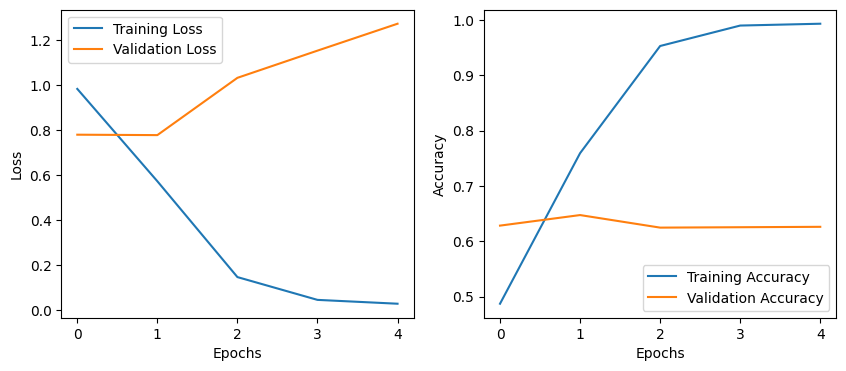

In [182]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming data['text_description'] contains the combined text and description
X = data['text_description']
y = encoder.fit_transform(data['gender'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Tokenize text data
max_words = 10000  # Maximum number of words to keep
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
max_sequence_length = 100  # Choose an appropriate value
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

# Create a simple neural network
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Assuming 3 classes (male, female, brand)
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_padded, y_train, epochs=5, validation_data=(X_test_padded, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Accuracy: {accuracy:.4f}')

# Predict probabilities for evaluation
y_pred_probs = model.predict(X_test_padded)

# Convert probabilities to class labels
y_pred = y_pred_probs.argmax(axis=1)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-score: {f1:.4f}')

# Calculate ROC-AUC score
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test, num_classes=3), y_pred_probs)
print(f'ROC-AUC Score: {roc_auc:.4f}')

# Calculate and print classification report
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

# Model training performance
history_dict = history.history

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


## Conclusions

I implemented a basline model of Gender classification based on the dataset provided on Kaggle.
This is actually an interesting problem among with the Sentiment classification problem, which is more popular.

The results show that Only the **Tweet text** can yield a moderate accuracy, although it's not substantially high.
But with the content from the **Description**, the classifiers actually improve its performance significantly.

The models fitted on other features do not yield good result, average accuracy is about 50%, which represents a random model. Further feature engineering and analysis should be conducted to make use of these features better, especially on `link_color` and `sidebar_color`, as they are shown to be different for different gender.

A trial attempt of using majority voting for models trained on **Tweet text** increase the accuracy slightly (0.4%).

As reported by [CrowdFlower AI](https://www.figure-eight.com/using-machine-learning-to-predict-gender/), their model can get to 60% of accuracy with a different approach (although the evaluation metrics may not be `accuracy`).